# UBC Scientific Software Seminar

November 3, 2017

* New York City Taxi Trip Duration
    * Feature creation: time and space
    * Remove outliers
    * Create route clusters
* Model making
    1. Include all the things!
    2. One model for each route
    3. Isolate by days of week and time of day

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Create features

In [2]:
trips = pd.read_csv('train.csv',parse_dates=[2,3])

In [3]:
trips.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Store and forward flag to numeric

Let's transform the `store_and_fwd_flag` column to numeric (1 is `Y` and 0 is `N`).

In [4]:
trips['store_and_fwd_flag'] = trips['store_and_fwd_flag'].map({'N':0, 'Y':1})

### Time features

We have time stamps for the pickup and dropoff times. Let's get the month, day, hour, minute, etc. for the pickup time.

In [5]:
trips['month'] = trips['pickup_datetime'].dt.month
trips['week'] = trips['pickup_datetime'].dt.week
trips['day'] = trips['pickup_datetime'].dt.day
trips['hour'] = trips['pickup_datetime'].dt.hour
trips['minute'] = trips['pickup_datetime'].dt.minute

The day of the week is a categorical variable and so let's do a one-hot encoding for it.

In [6]:
trips['dayofweek'] = trips['pickup_datetime'].dt.weekday_name
weekdays = pd.get_dummies(trips['dayofweek'])
trips = pd.concat([trips,weekdays],axis=1)

In [7]:
trips.drop(['dayofweek'],axis=1,inplace=True)

### Spatial features

We assume that the area of New York is small enough that we ignore the curvature of the Earth and so we can take longitude and latitude as coordinates. The SW corner of Central Park is at (-73.981920,40.768078) and the NW corner is at (-73.958166,40.800572). The angle between due North and the avenues is then: 

In [8]:
x1 = np.radians(-73.981920)
y1 = np.radians(40.768078)
x2 = np.radians(-73.958166)
y2 = np.radians(40.800572)
theta = np.arctan2(x2 - x1, y2 - y1)

In [9]:
theta*180/np.pi

36.167821891669846

Let's center the coordinates at the SW corner of central park and rotate the coordinates by $\theta$ so that the avenues run vertically in our coordinate system. This will make the L1 distance make more sense.

In [10]:
trips['x1'] = np.cos(theta) * (np.radians(trips['pickup_longitude']) - x1) - np.sin(theta) * (np.radians(trips['pickup_latitude']) - y1)
trips['y1'] = np.sin(theta) * (np.radians(trips['pickup_longitude']) - x1) + np.cos(theta) * (np.radians(trips['pickup_latitude']) - y1)
trips['x2'] = np.cos(theta) * (np.radians(trips['dropoff_longitude']) - x1) - np.sin(theta) * (np.radians(trips['dropoff_latitude']) - y1)
trips['y2'] = np.sin(theta) * (np.radians(trips['dropoff_longitude']) - x1) + np.cos(theta) * (np.radians(trips['dropoff_latitude']) - y1)

Multiplying the coordinates by the radius of the Earth (6371 km) transforms our coordinates into kilometers from the SW corner of Central Park.

In [11]:
trips[['x1','y1','x2','y2']] = 6371*trips[['x1','y1','x2','y2']]

Let's plot a sample of points to see that the streets are running horizontally and avenues are vertical.

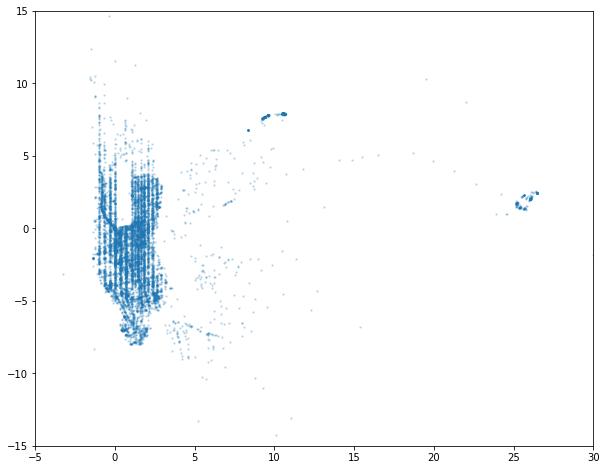

In [12]:
sample = trips.sample(10000)
plt.figure(figsize=(10,8))
plt.scatter(x=sample['x1'],y=sample['y1'],s=2,alpha=0.2)
plt.xlim([-5,30]), plt.ylim([-15,15]);

Therefore the L1 distance now makes sense:

In [13]:
trips['distance'] = np.abs(trips['x1'] - trips['x2']) + np.abs(trips['y1'] - trips['y2'])

We're done with the original pickup and dropoff longitude and latitude features and so we drop them.

In [14]:
trips.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)

## Remove outliers

### Distance outliers

In [15]:
trips[trips['distance'] == 0].shape

(5897, 24)

In [16]:
trips = trips[trips['distance'] > 0]

In [17]:
trips[trips['distance'] > 100].shape

(55, 24)

In [18]:
trips = trips[trips['distance'] < 100]

### Trip duration outliers

In [19]:
trips.sort_values(by='trip_duration',ascending=False).head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,store_and_fwd_flag,trip_duration,month,week,day,...,Saturday,Sunday,Thursday,Tuesday,Wednesday,x1,y1,x2,y2,distance
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,0,3526282,2,6,13,...,1,0,0,0,0,25.613439,2.271852,1.500562,-1.365232,27.749961
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,0,2227612,1,1,5,...,0,0,0,1,0,1.522331,-2.434330,2.330864,-3.860919,2.235123
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,0,2049578,2,6,13,...,1,0,0,0,0,7.561933,1.006637,0.277520,-0.912633,9.203683
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,0,1939736,1,1,5,...,0,0,0,1,0,25.430671,1.439423,1.925373,2.097368,24.163244
1234291,id1942836,2,2016-02-15 23:18:06,2016-02-16 23:17:58,2,0,86392,2,7,15,...,0,0,0,0,0,24.909932,1.233191,0.000949,-1.721685,27.863859


In [20]:
trips = trips[trips['trip_duration'] < 87000]

### Location outliers

In [21]:
trips.sort_values(by='x1').head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,store_and_fwd_flag,trip_duration,month,week,day,...,Saturday,Sunday,Thursday,Tuesday,Wednesday,x1,y1,x2,y2,distance
1184454,id2854272,2,2016-02-26 13:50:19,2016-02-26 13:58:38,2,0,499,2,8,26,...,0,0,0,0,0,-4082.727181,-3449.960464,-4082.732268,-3449.946318,0.019233
1068810,id3777240,2,2016-01-27 18:26:40,2016-01-27 18:45:05,2,0,1105,1,4,27,...,0,0,0,0,1,-4082.712086,-3449.960988,-4082.696580,-3449.976450,0.030968
656806,id2344725,2,2016-02-12 12:51:26,2016-02-12 13:02:50,1,0,684,2,6,12,...,0,0,0,0,0,-156.547748,-23.177789,-171.010959,-65.318070,56.603492
837346,id1948053,2,2016-03-23 10:30:14,2016-03-23 10:38:10,1,0,476,3,12,23,...,0,0,0,0,1,-54.104407,88.368202,-53.800286,88.116060,0.556263
73414,id0098463,1,2016-03-30 19:32:16,2016-03-30 20:25:26,2,0,3190,3,13,30,...,0,0,0,0,1,-49.161964,39.966893,0.159584,8.599699,80.688742


In [22]:
trips = trips[trips['x1'] > -70]

The other pickup and dropoff cooordinates have no such extreme outliers.

## Trips over 3 hours

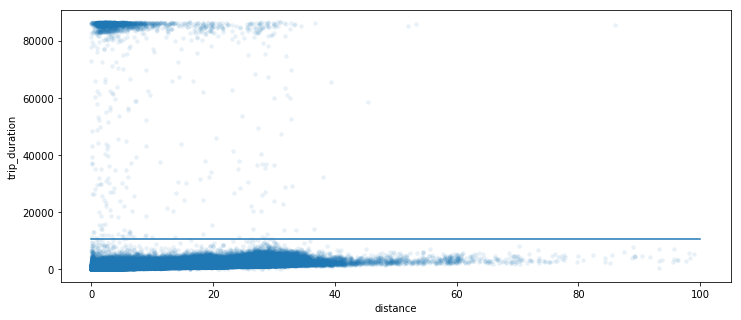

In [23]:
trips.plot(kind='scatter',x='distance',y='trip_duration',lw=0,alpha=0.1,figsize=(12,5))
plt.plot([0,100],[3*3600,3*3600]);

In [24]:
duration_outliers = trips[trips['trip_duration'] > 3*3600]

In [25]:
duration_outliers.shape

(2102, 24)

In [26]:
trips.shape

(1452685, 24)

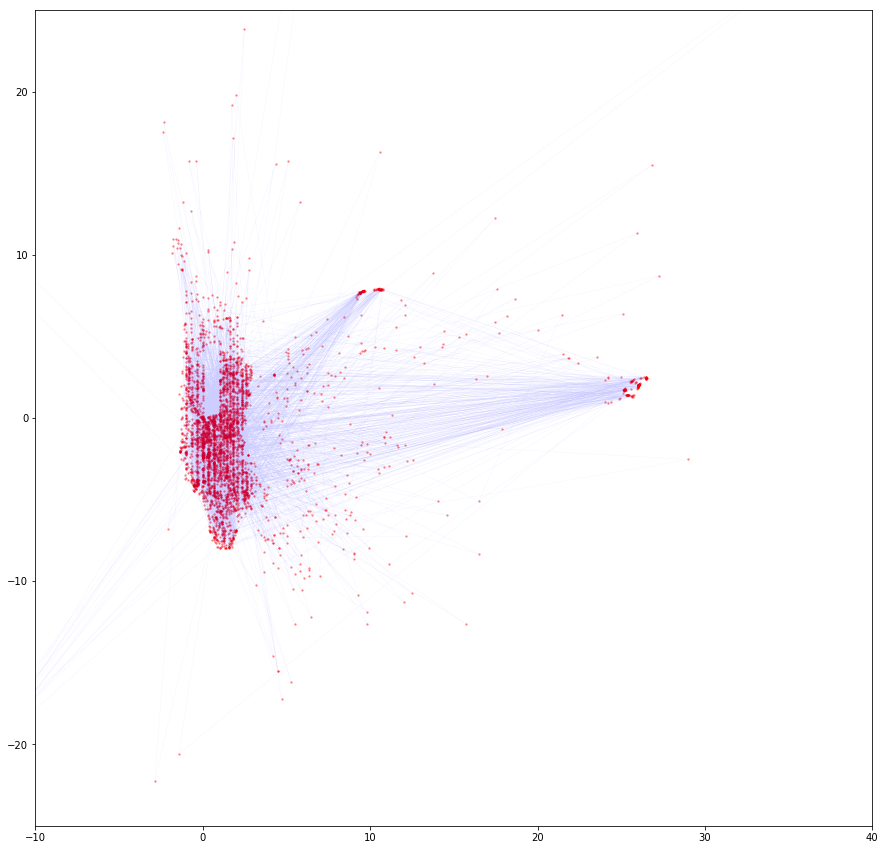

In [27]:
plt.figure(figsize=(15,15))
plt.plot(duration_outliers[['x1','x2']],duration_outliers[['y1','y2']],'b',lw=0.2,alpha=0.1)
plt.scatter(duration_outliers[['x1','x2']],duration_outliers[['y1','y2']],lw=0,s=5,alpha=0.5,c='red')
plt.xlim([-10,40])
plt.ylim([-25,25]);

I don't see a way to identify long trips. So let's throw them out!

In [28]:
trips = trips[trips['trip_duration'] < 3*3600]

## Create route clusters

Let's apply KMeans clustering to the 4D space of pickup and dropoff locations to find the 10 most common routes. We use MiniBatchKMeans since our dataset is quite large. (The number 100 is arbitrary...)

In [29]:
from sklearn.cluster import MiniBatchKMeans as KM

In [30]:
clf_routes = KM(n_clusters=100,batch_size=50000)

In [31]:
coordinates = ['x1','y1','x2','y2']
clf_routes.fit(trips[coordinates])

MiniBatchKMeans(batch_size=50000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

In [32]:
trips['route'] = clf_routes.labels_

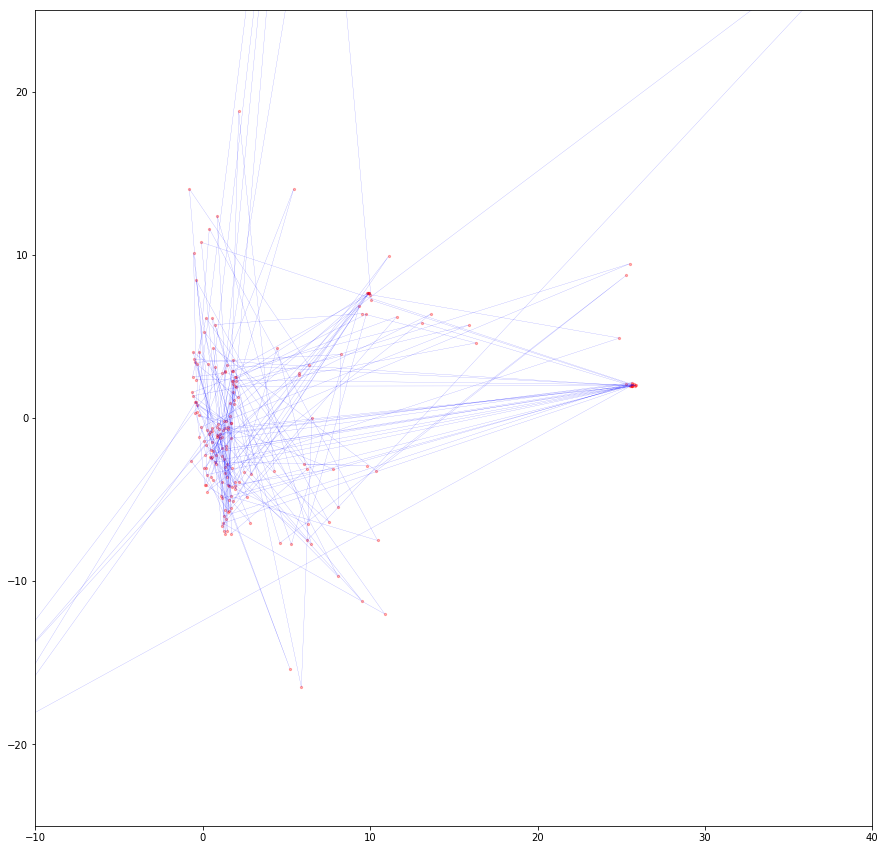

In [33]:
plt.figure(figsize=(15,15))
plt.plot(clf_routes.cluster_centers_[:,[0,2]],clf_routes.cluster_centers_[:,[1,3]],'b',lw=0.2,alpha=0.5)
plt.scatter(x=clf_routes.cluster_centers_[:,0],y=clf_routes.cluster_centers_[:,1],s=5,alpha=0.3,c='red')
plt.scatter(x=clf_routes.cluster_centers_[:,2],y=clf_routes.cluster_centers_[:,3],s=5,alpha=0.3,c='red')
plt.xlim([-10,40])
plt.ylim([-25,25]);

The route feature is categorical and so we should use one-hot encoding for the route... but that's a lot of new features and so we'll reconsider the routes later...

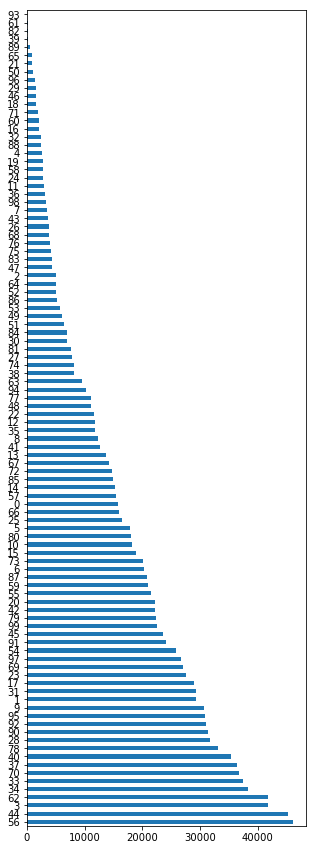

In [34]:
trips['route'].value_counts().plot(kind='barh',figsize=(5,15));

In [35]:
trips['route'].value_counts().tail()

89    589
39    207
82    193
61    144
93     37
Name: route, dtype: int64

## Attempt 1: Throw everything into a random forest regressor

In [36]:
print(trips.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'store_and_fwd_flag', 'trip_duration', 'month',
       'week', 'day', 'hour', 'minute', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'x1', 'y1', 'x2', 'y2',
       'distance', 'route'],
      dtype='object')


Let's drop the id, pickup/dropoff datetimes (because the sklearn algorithms don't understand datetime objects), trip duration and route.

In [37]:
X1 = trips.drop(['id','pickup_datetime','dropoff_datetime','trip_duration'],axis=1).copy()
y1 = trips['trip_duration'].copy()

Let's split the data into a training set and a testing set, and then let's throw a random forest regressor at it!

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,test_size=0.2)

In [40]:
from sklearn.ensemble import RandomForestRegressor as RFR

In [41]:
reg1 = RFR(n_estimators=20,max_depth=5,verbose=1)

In [42]:
reg1.fit(X1_train,y1_train)

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.0min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

Let's evaluate the model!

In [43]:
from sklearn.metrics import mean_squared_log_error as MLSE

In [44]:
MLSE(y1_test,reg1.predict(X1_test))**0.5

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished


0.45429185718409071

In [45]:
reg1_features = pd.DataFrame(reg1.feature_importances_,index=X1_train.columns,columns=['Importance'])

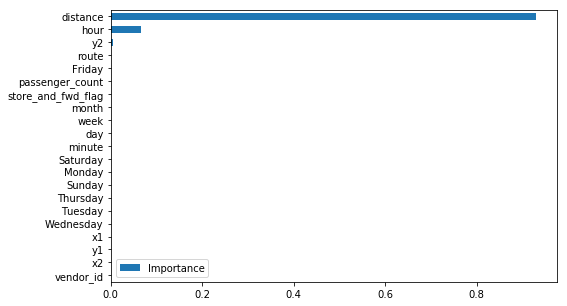

In [46]:
reg1_features.sort_values(by='Importance').plot(kind='barh',figsize=(8,5))

Ha! Only the hour of the day and distance matter. Let's try again and throw out everything but the distance and time of day.

## Attempt 2: Distance and hour of the day

In [47]:
X2 = trips[['distance','hour']].copy()
y2 = trips['trip_duration'].copy()

In [48]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,test_size=0.2)

In [49]:
reg2 = RFR(n_estimators=50,max_depth=8)

In [50]:
reg2.fit(X2_train,y2_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [51]:
MLSE(y2_test,reg2.predict(X2_test))**0.5

0.43580390850736139

## Attempt 3: Isolate routes

We have 100 route clusters and using one-hot encoding would create too many features... my laptop couldn't train the dataset! Instead, let's create a random forest regressor for each route!

In [52]:
X3 = trips.drop(['id','pickup_datetime','dropoff_datetime','trip_duration'],axis=1).copy()
y3 = trips['trip_duration'].copy()

In [53]:
n_routes = trips['route'].max() + 1

In [54]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3,test_size=0.2)

In [55]:
route_regs = []
for route in range(0,n_routes):
    route_reg = RFR(n_estimators=30,max_depth=10)
    route_index = X3_train['route'] == route
    route_reg.fit(X3_train[route_index],y3_train[route_index])
    route_regs.append(route_reg)
    #reg_features = pd.DataFrame(route_reg.feature_importances_,index=X3_train.columns,columns=['Importance'])
    #features = reg_features.sort_values(by='Importance').tail().transpose()
    #print(features)

To make our prediction, we need to loop over the routes, select the samples from the test data from that route, predict and gather all the predictions in a dataframe.

In [56]:
results = pd.DataFrame(columns=['prediction','target'])
for route in range(0,n_routes):
    route_index = X3_test['route'] == route
    predictions = route_regs[route].predict(X3_test[route_index])
    targets = y3_test[route_index]
    result = pd.DataFrame({'prediction': predictions, 'target':targets})
    results = pd.concat([results,result],axis=0)

In [57]:
MLSE(results['target'],results['prediction'])**0.5

0.37574012097781689

## Attempt 4: Isolate by day and hour

In [58]:
X4 = trips.drop(['id','trip_duration'],axis=1).copy()
y4 = trips['trip_duration'].copy()

In [59]:
X4['weekday'] = X4['pickup_datetime'].dt.weekday

In [60]:
X4 = X4[['weekday','hour','x1','y1','x2','y2']]

In [61]:
from sklearn.neighbors import KNeighborsRegressor as KNR

In [62]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y4,test_size=0.2)

In [63]:
time_regs = {day:{} for day in range(0,7)}
for day in range(0,7):
    for hour in range(0,24):
        time_reg = KNR(n_neighbors=10)
        time_index = (X4_train['hour'] == hour) & (X4_train['weekday'] == day)
        time_reg.fit(X4_train[time_index][['x1','y1','x2','y2']],y4_train[time_index])
        time_regs[day][hour] = time_reg

In [64]:
results = pd.DataFrame(columns=['prediction','target'])
for day in range(0,7):
    for hour in range(0,24):
        time_index = (X4_test['hour'] == hour) & (X4_test['weekday'] == day)
        predictions = time_regs[day][hour].predict(X4_test[time_index][['x1','y1','x2','y2']])
        targets = y4_test[time_index]
        result = pd.DataFrame({'prediction': predictions, 'target':targets})
        results = pd.concat([results,result],axis=0)

In [65]:
MLSE(results['target'],results['prediction'])**0.5

0.41331981767720227

## Make a submission using Attempt 3

In [66]:
test = pd.read_csv('test.csv',parse_dates=[2,3])

### Prepare the test data

In [67]:
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].map({'N':0, 'Y':1})
test['month'] = test['pickup_datetime'].dt.month
test['week'] = test['pickup_datetime'].dt.week
test['day'] = test['pickup_datetime'].dt.day
test['hour'] = test['pickup_datetime'].dt.hour
test['minute'] = test['pickup_datetime'].dt.minute
test['dayofweek'] = test['pickup_datetime'].dt.weekday_name
weekdays = pd.get_dummies(test['dayofweek'])
test = pd.concat([test,weekdays],axis=1)
x1 = np.radians(-73.981920)
y1 = np.radians(40.768078)
x2 = np.radians(-73.958166)
y2 = np.radians(40.800572)
theta = np.arctan2(x2 - x1, y2 - y1)
theta*180/np.pi
test['x1'] = np.cos(theta) * (np.radians(test['pickup_longitude']) - x1) - np.sin(theta) * (np.radians(test['pickup_latitude']) - y1)
test['y1'] = np.sin(theta) * (np.radians(test['pickup_longitude']) - x1) + np.cos(theta) * (np.radians(test['pickup_latitude']) - y1)
test['x2'] = np.cos(theta) * (np.radians(test['dropoff_longitude']) - x1) - np.sin(theta) * (np.radians(test['dropoff_latitude']) - y1)
test['y2'] = np.sin(theta) * (np.radians(test['dropoff_longitude']) - x1) + np.cos(theta) * (np.radians(test['dropoff_latitude']) - y1)
test[['x1','y1','x2','y2']] = 6371*test[['x1','y1','x2','y2']]
test['distance'] = np.abs(test['x1'] - test['x2']) + np.abs(test['y1'] - test['y2'])
test.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)
test['route'] = clf_routes.predict(test[['x1','y1','x2','y2']])

test_id = test['id']
test = test[X3.columns]

### Train the model on all the data

In [68]:
route_regs = []
for route in range(0,n_routes):
    route_reg = RFR(n_estimators=30,max_depth=10)
    route_index = X3['route'] == route
    route_reg.fit(X3[route_index],y3[route_index])
    route_regs.append(route_reg)

### Make predictions and submit

In [69]:
results = pd.DataFrame(columns=['id','trip_duration'])
for route in range(0,n_routes):
    route_index = test['route'] == route
    predictions = route_regs[route].predict(test[route_index])
    ids = test_id[route_index]
    result = pd.DataFrame({'id':ids,'trip_duration': predictions})
    results = pd.concat([results,result],axis=0)

In [70]:
results.to_csv('submission.csv',index=False)

This model scores 0.437. About middle of the pack (600/1200) on Kaggle.